In [1]:
import numpy as np
np.set_printoptions(precision=2)

import qiskit
from qiskit.visualization import *
import qiskit.aqua.components.optimizers as optimizers
import qiskit.aqua.components.variational_forms as variational_forms

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

### Single qubit variational form
From scratch

In [2]:
class VariationalForm:

    def __init__(self, backend, iterations):
        self._circuit = qiskit.QuantumCircuit(self.num_qubits)

        self.theta = qiskit.circuit.Parameter('theta')
        self.phi = qiskit.circuit.Parameter('phi')
        self.lamda = qiskit.circuit.Parameter('lamda')

        self._circuit.u3(self.theta, self.phi, self.lamda, 0)
        self._circuit.measure_all()
        
        self.backend = backend
        self.iterations = iterations
    
    @property
    def num_parameters(self):
        return len(self._circuit.parameters)
    
    @property
    def num_qubits(self):
        # Unnecessary overhead
        return 1
    
    def run(self, params):
        # Calculate probabilities of variational form states
        job = qiskit.execute(self._circuit, 
                             self.backend, 
                             shots = self.iterations,
                             parameter_binds = [{self.theta: params[0], 
                                                 self.phi: params[1],
                                                 self.lamda: params[2]}])
        result = job.result().get_counts(self._circuit)
        
        counts = np.array(list(result.values()))
        states = [int(key, 2) for key in np.array(list(result.keys()))]
        
        # Filling in not represented states with zeros
        probabilities = np.zeros(2 ** self.num_qubits) 
        probabilities[states] = counts
        probabilities /= self.iterations

        return np.array(probabilities)

States' probability: [0.51 0.49]


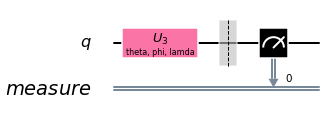

In [3]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

circuit = VariationalForm(simulator, 100)
print("States' probability: {}".format(circuit.run([np.pi / 2, np.pi / 3, 1])))
circuit._circuit.draw()

In [4]:
import scipy.spatial.distance as distance

def loss(circuit, y_true):
    """ Loss function: Manhattan distance between two distributions """
    return lambda params: distance.cityblock(circuit.run(params), y_true)

#### Defining target distribution

In [5]:
def getDistribution(dims):
    distribution = np.random.rand(dims)
    distribution /= np.sum(distribution)
    return distribution

Target distribution: [0.5 0.5]


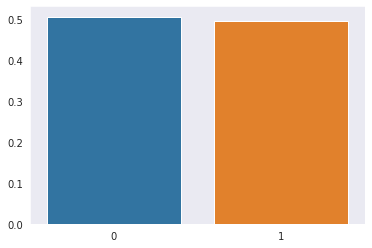

In [6]:
target_distribution = getDistribution(2)

sns.barplot(x = np.arange(len(target_distribution)), y = target_distribution)
print('Target distribution: {}'.format(target_distribution))

#### Running variational form with Constrained Optimization by Linear Approximation optimizer

In [7]:
simulator = qiskit.Aer.get_backend('qasm_simulator')
circuit = VariationalForm(simulator, 100)

# Constrained Optimization by Linear Approximation optimizer
optimizer = optimizers.COBYLA(maxiter = 100, tol = 1e-4)
params, error, _ = optimizer.optimize(num_vars = circuit.num_parameters,
                                      objective_function = loss(circuit, target_distribution), 
                                      initial_point = np.random.rand(circuit.num_parameters))

predicted_distribution = circuit.run(params)

print("Target distribution:       {}".format(target_distribution))
print("Predicted distribution:    {}".format(predicted_distribution))
print("Prediction error:          {0:0.4f}".format(error))

Target distribution:       [0.5 0.5]
Predicted distribution:    [0.56 0.44]
Prediction error:          0.1098


### Multi qubit variational forms
Existing implementations

#### Defining helper functions

In [8]:
def run(variational_form, params, backend, iterations):
    """ Calculate probabilities of variational form states """
    circuit = variational_form.construct_circuit(params)
    circuit.measure_all()
    
    job = qiskit.execute(circuit, 
                         backend, 
                         shots = iterations)
    
    result = job.result().get_counts(circuit)
    
    counts = np.array(list(result.values()))
    states = [int(key, 2) for key in np.array(list(result.keys()))]

    probabilities = np.zeros(2 ** len(circuit.qubits)) 
    probabilities[states] = counts
    probabilities /= iterations
    
    return np.array(probabilities)
    
def loss(variational_form, backend, iterations, y_true):
    return lambda params: distance.cityblock(run(variational_form, params, backend, iterations), y_true)

#### Defining target distribution

Target distribution: [0.1  0.16 0.01 0.19 0.16 0.17 0.07 0.15]


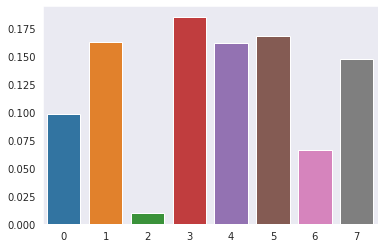

In [9]:
n_qubits = 3
target_distribution = getDistribution(2 ** n_qubits)

sns.barplot(x = np.arange(len(target_distribution)), y = target_distribution)
print('Target distribution: {}'.format(target_distribution))

### RYRZ variational form

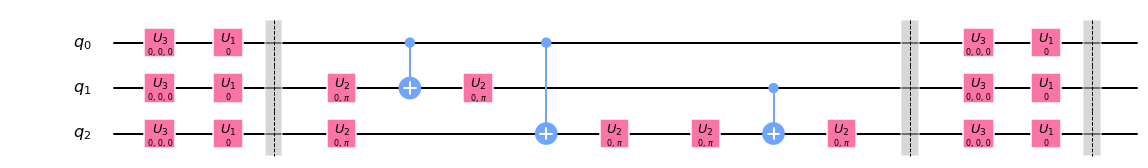

In [10]:
variational_form = variational_forms.RYRZ(num_qubits = n_qubits, 
                                          depth = 1,
                                          entanglement = "full")

circuit = variational_form.construct_circuit([0] * variational_form.num_parameters)
circuit.draw()

In [11]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

optimizer = optimizers.COBYLA(maxiter = 500, tol = 1e-5)
params, error, _ = optimizer.optimize(num_vars = variational_form.num_parameters,
                                      objective_function = loss(variational_form, 
                                                                simulator,
                                                                1000,
                                                                target_distribution), 
                                      initial_point = np.random.rand(variational_form.num_parameters))

predicted_distribution = run(variational_form, params, simulator, 1000)

print("Target distribution:       {}".format(target_distribution))
print("Predicted distribution:    {}".format(predicted_distribution))
print("Prediction error:          {0:0.4f}".format(error))

Target distribution:       [0.1  0.16 0.01 0.19 0.16 0.17 0.07 0.15]
Predicted distribution:    [0.11 0.14 0.03 0.18 0.22 0.08 0.06 0.18]
Prediction error:          0.1857


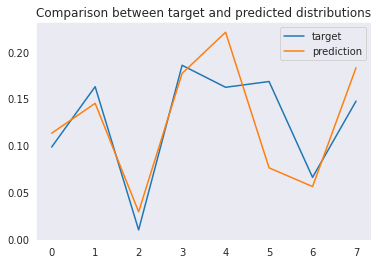

In [12]:
plt.plot(target_distribution, label='target')
plt.plot(predicted_distribution, label='prediction')
plt.legend()
plt.title('Comparison between target and predicted distributions')
plt.show()

### RY variational form

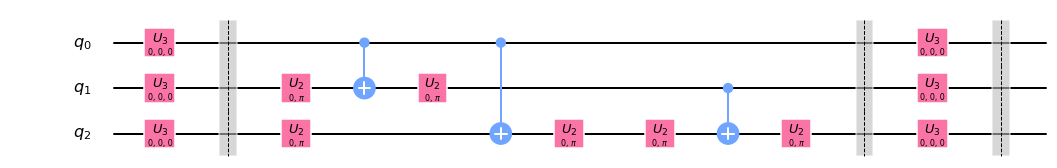

In [13]:
variational_form = variational_forms.RY(num_qubits = n_qubits, 
                                        depth = 1,
                                        entanglement = "full")

circuit = variational_form.construct_circuit([0] * variational_form.num_parameters)
circuit.draw()

In [14]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

optimizer = optimizers.COBYLA(maxiter = 500, tol = 1e-5)
params, error, _ = optimizer.optimize(num_vars = variational_form.num_parameters,
                                      objective_function = loss(variational_form, 
                                                                simulator,
                                                                1000,
                                                                target_distribution), 
                                      initial_point = np.random.rand(variational_form.num_parameters))

predicted_distribution = run(variational_form, params, simulator, 1000)

print("Target distribution:       {}".format(target_distribution))
print("Predicted distribution:    {}".format(predicted_distribution))
print("Prediction error:          {0:0.4f}".format(error))

Target distribution:       [0.1  0.16 0.01 0.19 0.16 0.17 0.07 0.15]
Predicted distribution:    [0.09 0.22 0.01 0.19 0.15 0.18 0.15 0.01]
Prediction error:          0.3296


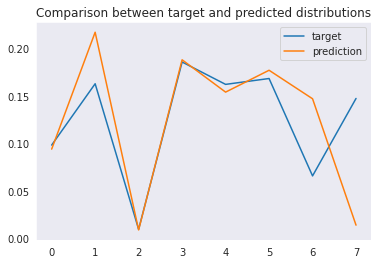

In [15]:
plt.plot(target_distribution, label='target')
plt.plot(predicted_distribution, label='prediction')
plt.legend()
plt.title('Comparison between target and predicted distributions')
plt.show()

### Literature:

1. Abraham Asfaw et al., Learn Quantum Computation Using Qiskit, 2020, https://qiskit.org/textbook/ch-applications/vqe-molecules.html